<h3> [MUCURI] Previsão de horas a frente </h3>

Importando o tensorflow, o keras e as bibliotecas que serão usadas

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Activation
from tensorflow.python.keras.optimizers import adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

import ai_utils.metrics as ai
import sklearn as sk

Lendo o dataset e tratando os valores nulos 

In [2]:
Mucuri = pd.read_csv('./train150_mucuri.txt', sep='\t', header = None)
Mucuri.update(Mucuri[6].fillna(Mucuri[6].mean()))
Mucuri.describe()

,0,1,2,3,4,5,6,7,8
count,550.000000,550.000000,550.0,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000
mean,12.087273,11.981818,2015.0,11.496364,8.176719,73.027647,24.443445,85.263578,1017.313986
std,6.891273,0.133730,0.0,6.940745,2.724988,64.996263,1.668117,8.579562,8.796185
min,1.000000,11.000000,2015.0,0.000000,1.211905,1.448179,20.616279,46.355556,937.534333
25%,6.000000,12.000000,2015.0,5.250000,6.215278,38.605367,23.315657,80.942222,1016.544542
50%,12.000000,12.000000,2015.0,11.000000,8.320000,59.019307,24.338280,86.765805,1020.046750
75%,18.000000,12.000000,2015.0,17.750000,10.146806,83.329498,25.359083,91.434531,1021.497917
max,30.000000,12.000000,2015.0,23.000000,13.572222,356.553715,30.140625,98.000000,1023.726500


Transformando o dataset em um numpy array e separando a coluna da velocidade do vento

In [3]:
x_array = Mucuri.values 
y_array = list(Mucuri[4].values)

Criando o modelo da rede

In [4]:
def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(9, activation='relu', input_shape=(9,)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
  ])

  model.compile(optimizer='adam',
                loss='mse',
                metrics=['mae'])
  return model

Treinando a rede em 6 épocas

In [5]:
model = get_compiled_model()
history = model.fit(x_array, y_array, epochs=6)

W0828 15:08:46.109520 10120 deprecation.py:506] From D:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/6
550/550 [==============================] - 0s 216us/sample - loss: 71.5496 - mean_absolute_error: 6.8118
Epoch 2/6
550/550 [==============================] - 0s 42us/sample - loss: 52.4734 - mean_absolute_error: 5.9304
Epoch 3/6
550/550 [==============================] - 0s 40us/sample - loss: 48.8335 - mean_absolute_error: 5.7253
Epoch 4/6
550/550 [==============================] - 0s 53us/sample - loss: 47.0900 - mean_absolute_error: 5.5773
Epoch 5/6
550/550 [==============================] - 0s 45us/sample - loss: 44.0052 - mean_absolute_error: 5.3979
Epoch 6/6
550/550 [==============================] - 0s 45us/sample - loss: 41.7980 - mean_absolute_error: 5.3063


In [6]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error'])


Gráfico de evolução do loss ao longo das épocas de treinamento

[71.54960024746981, 52.47342620849609, 48.833525099320845, 47.08999428488991, 44.005234985351564, 41.79801981839267]


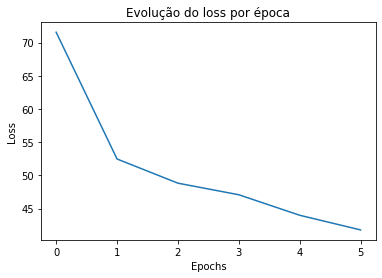

In [7]:
print(history.history['loss'])
plt.plot(history.history['loss'])
plt.title('Evolução do loss por época')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [8]:
lossEvaluate, acc = model.evaluate(x_array, y_array)

550/550 [==============================] - 0s 60us/sample - loss: 38.8007 - mean_absolute_error: 5.0877


In [9]:
print(lossEvaluate)

38.80066468672319


Manipulando o dataset para previsão

In [18]:
p1_array = x_array[1:550, 0:4]
p2_array = x_array[0:549, 5:]
w_array = model.predict(x_array)
w_array = w_array[0:549, :]

print(w_array.shape)
print(p1_array.shape)
print(p2_array.shape)

new_array = np.hstack((p1_array, w_array, p2_array))

(549, 1)
(549, 4)
(549, 4)


Métricas para avaliação: R, R2, Fac2, MSE e MAE

In [21]:
vel = model.predict(new_array)
mae = sk.metrics.mean_absolute_error(w_array, vel)
mse = sk.metrics.mean_squared_error(w_array, vel)
R2 = sk.metrics.r2_score(w_array, vel)
print('MAE: ', mae)
print('MSE: ', mse)
print('R2: ', R2)

MAE:  0.29291555
MSE:  0.6311909
R2:  0.9596744858118311


In [37]:
predconvert = tf.convert_to_tensor(vel)
realconvert = tf.convert_to_tensor(w_array)
R = ai.pearson_r(realconvert, predconvert)
Fac2 = ai.fac2(realconvert, predconvert)
#x = tf.dtypes.cast(R, tf.float32)
#y = tf.dtypes.cast(Fac2, tf.float32)
print('R: ', R)
print('Fac2: ', Fac2)

R:  Tensor("truediv_24:0", shape=(), dtype=float32)
Fac2:  Tensor("Mean_38:0", shape=(), dtype=float32)
